In [1]:
import StringIO
import time
import pandas as pd
import datetime

HOST = 'http://mtgray03k.yandex.ru:8123'
HOST = 'http://mtlog01-01-1.yandex.ru:8123'
HOST = 'http://clickhouse.metrika.yandex.net:8123'
#HOST = 'http://mtsmart001-1.yandex.ru:8123'
HOST = 'http://mtch01k.metrika.yandex.net:8123'

import requests

def get_clickhouse_data(query, host = HOST, connection_timeout = 1500):
    NUMBER_OF_TRIES = 30
    DELAY = 10
    
    for i in range(NUMBER_OF_TRIES):
        r = requests.post(host, 
                          params = {'timeout_before_checking_execution_speed': 120}, 
                          timeout = connection_timeout, data = query,
                          auth = ('miptgirl', '1QwBgINk')
                         )
        if r.status_code == 200:
            return r.text
        else:
            print 'ATTENTION: try #%d failed' % i
            if i != (NUMBER_OF_TRIES-1):
                #print query
                print r.text
                time.sleep(DELAY*(i+1))
            else:
                raise ValueError, r.text 
        
def get_clickhouse_df(query, host = HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(StringIO.StringIO(data), sep = '\t')
    return df

def upload(table, content, host=HOST):
    '''Uploads data to table in ClickHous'''
    content = content.encode('utf-8')
    query_dict = {
             'query': 'INSERT INTO ' + table + ' FORMAT TabSeparatedWithNames '
        }
    r = requests.post(host, data=content, params=query_dict, auth = ('miptgirl', '1QwBgINk'))
    result = r.text
    if r.status_code == 200:
        return result
    else:
        raise ValueError(r.text)

In [2]:
import sys
stdin, stdout, stderr = sys.stdin, sys.stdout, sys.stderr
reload(sys)
sys.stdin, sys.stdout, sys.stderr = stdin, stdout, stderr
sys.setdefaultencoding('utf8')

In [3]:
def df_to_wiki(df, show_index = False):
    print '#|\n ||' + df.to_csv(index = show_index, sep = '|').replace('|', ' | ').replace('\n', '|| \n ||')[:-2] + '|#'

In [113]:
%%time
q = '''
select
    CounterID as counter_id,
    anyHeavy(StartURLDomain) as domain,
    uniq(UserID) as total_users,
    sum(Sign) as total_visits,
    sumIf(Sign, length(EAction.ProductName) != 0) as ecomm_visits,
    sumIf(Sign, length(PublisherEvents.ArticleID) != 0) as pub_visits,
    sumIf(Sign, TraficSourceID = 3) as ads_visits,
    sumIf(Sign, (TraficSourceID = 3) and (AdvEngineID = 1)) as yadirect_visits,
    sumIf(Sign, length(Goals.ID) != 0) as goal_visits,
    sumIf(Sign, IsTurboPage) as turbo_visits,
    sumIf(Sign, IsMobile) as mobile_visits
from visits_all
where StartDate >= '2019-12-16'
    and StartDate <= '2019-12-22'
    and CounterClass = 0
group by counter_id
format TSVWithNames
'''

counters_df = get_clickhouse_df(q)

CPU times: user 3.88 s, sys: 804 ms, total: 4.68 s
Wall time: 6min 45s


In [114]:
%%time
q = '''
select
    counter_id,
    count() as num_goals
from
    (select distinct
        CounterID as counter_id,
        arrayJoin(Goals.ID) as goal_id
    from visits_all
    where StartDate >= '2019-12-16'
        and StartDate <= '2019-12-22'
        and CounterClass = 0)
group by counter_id
format TSVWithNames
'''

counters_goals_df = get_clickhouse_df(q)

CPU times: user 152 ms, sys: 8 ms, total: 160 ms
Wall time: 15.8 s


In [115]:
counters_df = counters_df.merge(counters_goals_df, how = 'left').fillna(0)

In [116]:
counters_df.to_csv('all_counters_data.csv', index = False, sep = '\t')

In [117]:
counters_df.shape

(2284126, 12)

In [118]:
(
    counters_df[counters_df.total_users >= 1000].shape[0], 
    counters_df[counters_df.total_users >= 10000].shape[0], 
    counters_df[counters_df.total_users >= 100000].shape[0]
)

(218982, 45581, 7906)

In [119]:
counters_df['ecomm_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.ecomm_visits,
    counters_df.total_visits
)

counters_df['pub_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.pub_visits,
    counters_df.total_visits
)

counters_df['turbo_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.turbo_visits,
    counters_df.total_visits
)

counters_df['ads_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.ads_visits,
    counters_df.total_visits
)

counters_df['yadirect_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.yadirect_visits,
    counters_df.total_visits
)

counters_df['yadirect_ads_share'] = map(
    lambda x, y: round(100.*x/y, 2) if y != 0 else 0,
    counters_df.yadirect_visits,
    counters_df.ads_visits
)

counters_df['goal_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.goal_visits,
    counters_df.total_visits
)

counters_df['mobile_share'] = map(
    lambda x, y: round(100.*x/y, 2),
    counters_df.mobile_visits,
    counters_df.total_visits
)

In [120]:
counters_df.sort_values('total_visits', ascending = False, inplace = True)

In [121]:
counters_df_filt = counters_df[counters_df.total_users >= 10000]

In [122]:
counters_df_filt.shape[0]

45581

In [123]:
counters_df_filt[counters_df_filt.pub_share >= 10].shape[0]

1813

In [124]:
counters_df_filt[counters_df_filt.ecomm_share >= 10].shape[0]

2317

In [143]:
%matplotlib inline
import seaborn

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Text(0.5,1,'Publishers share')

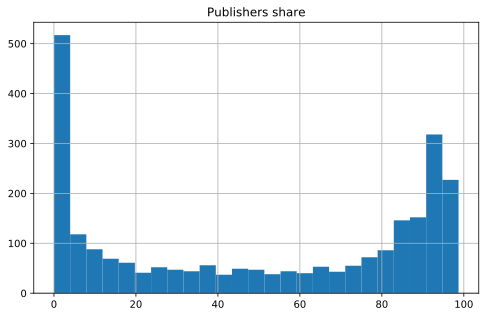

In [153]:
ax = counters_df_filt[counters_df_filt.pub_share != 0].pub_share.hist(bins = 25)
ax.set_title('Publishers share')

Text(0.5,1,'Ecommerce share')

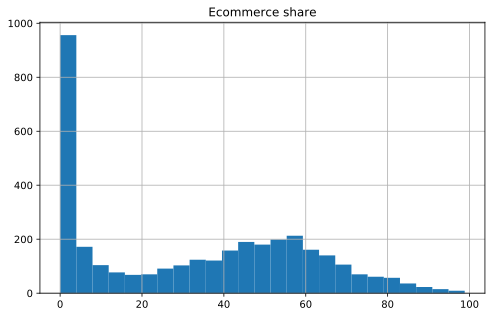

In [154]:
ax = counters_df_filt[counters_df_filt.ecomm_share != 0].ecomm_share.hist(bins = 25)
ax.set_title('Ecommerce share')

Text(0.5,1,'Turbo share')

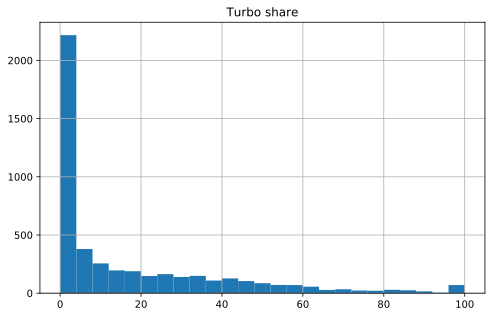

In [155]:
ax = counters_df_filt[counters_df_filt.turbo_share != 0].turbo_share.hist(bins = 25)
ax.set_title('Turbo share')

Text(0.5,1,'Yandex Direct share')

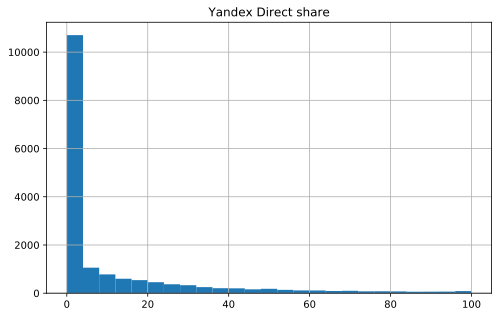

In [156]:
ax = counters_df_filt[counters_df_filt.yadirect_share != 0].yadirect_share.hist(bins = 25)
ax.set_title('Yandex Direct share')

Text(0.5,1,'Ads share')

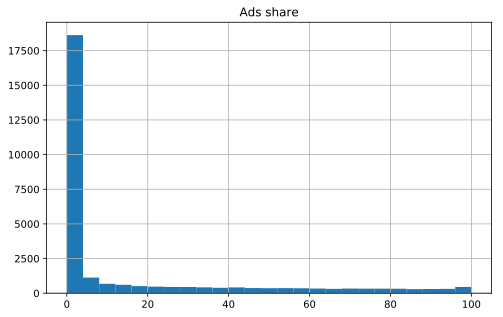

In [157]:
ax = counters_df_filt[counters_df_filt.ads_share != 0].ads_share.hist(bins = 25)
ax.set_title('Ads share')

Text(0.5,1,'Goals traffic share')

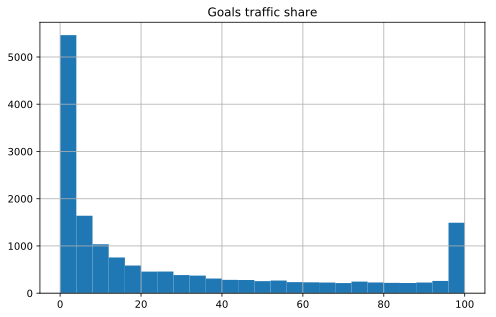

In [158]:
ax = counters_df_filt[counters_df_filt.goal_share != 0].goal_share.hist(bins = 25)
ax.set_title('Goals traffic share')

Text(0.5,1,'Num goals')

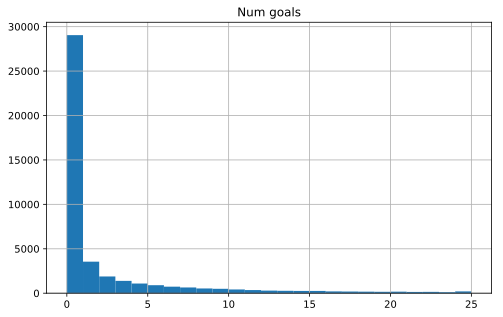

In [161]:
ax = counters_df_filt[counters_df_filt.num_goals <= 25].num_goals.hist(bins = 25)
ax.set_title('Num goals')

In [150]:
counters_df_filt.num_goals.value_counts().head(10)

0.0    29045
1.0     3547
2.0     1885
3.0     1386
4.0     1086
5.0      900
6.0      736
7.0      646
8.0      529
9.0      493
Name: num_goals, dtype: int64

In [151]:
counters_df_filt['has_ecomm'] = map(
    lambda x: 1 if x >= 10 else 0,
    counters_df_filt.ecomm_share
)

counters_df_filt['has_pub'] = map(
    lambda x: 1 if x >= 10 else 0,
    counters_df_filt.pub_share
)

counters_df_filt['has_turbo'] = map(
    lambda x: 1 if x >= 1 else 0,
    counters_df_filt.turbo_share
)

counters_df_filt['has_yadirect'] = map(
    lambda x: 1 if x >= 5 else 0,
    counters_df_filt.yadirect_share
)

counters_df_filt['has_goals_traffic'] = map(
    lambda x: 1 if x >= 1 else 0,
    counters_df_filt.goal_share
)

counters_df_filt['has_goals_num'] = map(
    lambda x: 1 if x >= 3 else 0,
    counters_df_filt.num_goals
)

/home/miptgirl/jupyterenv/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/miptgirl/jupyterenv/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/miptgirl/jupyterenv/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [159]:
total_counters = counters_df_filt.shape[0]
for p in ['has_ecomm', 'has_pub', 'has_turbo', 'has_yadirect',
    'has_goals_traffic', 'has_goals_num']:
    counters = counters_df_filt[counters_df_filt[p] == 1].shape[0]
    print p, counters, round(100.*counters/total_counters, 2)

has_ecomm 2317 5.08
has_pub 1813 3.98
has_turbo 3242 7.11
has_yadirect 5905 12.95
has_goals_traffic 13457 29.52
has_goals_num 11104 24.36


In [166]:
fin_df = counters_df_filt[(counters_df_filt.has_ecomm == 1) | 
                 (counters_df_filt.has_pub == 1) |
                 (counters_df_filt.has_turbo == 1) | 
                 (counters_df_filt.has_yadirect == 1) |
                 (counters_df_filt.has_goals_traffic == 1) |
                 (counters_df_filt.has_goals_num == 1)
                ]

In [190]:
import mysql.connector
from mysql.connector.errors import Error
def conv_main(query, header=True):
    """
    Простенькая функция для mysql. По дефолту идет в базу conv_main. Можно выключить заголовок
    """
    db = mysql.connector.connect(user=get_config()['mysql_login'], 
                                 password=get_config()['mysql_password'], 
                                 host="https://mtacs-x01e.yandex.ru", port=3306, 
                                 database='conv_main', charset='utf8')
    cursor = db.cursor()
    cursor.execute(query)
    all_data = cursor.fetchall()
    field_names = [i[0] for i in cursor.description]
    data = '\n'.join(['\t'.join([convert_to_string(item) for item in one]) for one in all_data])
    if header:
        data = '\t'.join(field_names) + '\n' + data
    return data

In [193]:
from yql.api.v1.client import YqlClient
DEFAULT_DB = 'hahn'
DEFAULT_HEADER = """
PRAGMA yt.PoolTrees = "physical";
PRAGMA yt.TentativePoolTrees = "cloud";
PRAGMA SimpleColumns;"""

def run_yql_wait_and_return(query='', token='', db=DEFAULT_DB, add_default_header=True, syntax_version=1):
    with YqlClient(db=db, token=token) as client:
        if add_default_header:
            query = DEFAULT_HEADER + query
        request = client.query(query, syntax_version=syntax_version)
        request.run()
        result = request.get_results()
        if not request.is_success:
            status = request.status
            errors = '\n'.join([str(x) for x in result.errors]) if result.errors else 'No messages'
            error_message = """There is an error in YQL api request. Status: {status}\nErrors: '{errors}'""".format(
                status=status,
                errors=errors)
            raise(BaseException(error_message))
    return request.full_dataframe

In [195]:
import vault_client
import getpass

from os.path import expanduser
import json

def get_config():
    home = expanduser("~")
    
    with open(home + '/config.json') as f:
        config_data = f.read()
    config = json.loads(config_data)
    return config

yav = vault_client.instances.Production(
    rsa_login='miptgirl', 
    authorization='OAuth {}'.format(get_config()['vault_api_token']),)

ver = 'ver-01dssnc1zdezgbfd48xhj9j9xn'
YT_TOKEN = yav.get_version(ver)['value']['yt_token']
YQL_TOKEN = yav.get_version(ver)['value']['yql_token']
SOLOMON_TOKEN = yav.get_version(ver)['value']['solomon_token']

In [197]:
q = 'select counter_id, name from `//home/metrika/counters`'
counters_df = run_yql_wait_and_return(q, token = YQL_TOKEN)

In [199]:
fin_df = fin_df.merge(counters_df, how = 'left')

In [200]:
fin_df.shape

(18020, 27)

In [201]:
fin_df.to_csv('potential_beta_counters.csv', index = False)